# Part II (Swaption Calibration)
We start by importing the following needed for our computation:
1. Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq, minimize, least_squares
from scipy.interpolate import interp1d

2. Dataset: Lognormal implied volatilities for IR swaptions (100 bps = 1%)

Assume that, if a swaption is at at-the-money (ATM), then its strike price, $K = \text{Forward price} + \text{Basis points (bps)}$ coincides with 0 bps.

In [2]:
swaption_df = pd.read_excel('IR Data.xlsx', sheet_name='Swaption', skiprows=2)
swaption_df_pivoted = swaption_df.melt(id_vars=["Expiry", "Tenor"], var_name="delta", value_name="impliedVol")

# Load the par swap rate data from part 1
par_swap_rate_df = pd.read_csv("par_swap_rate.csv")
par_swap_rate_df = par_swap_rate_df.rename(columns={"Unnamed: 0": "Expiry"})
par_swap_rate_df_pivoted = par_swap_rate_df.melt(id_vars="Expiry", var_name="Tenor", value_name="parSwap")

# Load the discount factors from part 1
discount_factors_df = pd.read_csv("discount_factors.csv")
discount_factors_df = discount_factors_df[["Tenor", "OIS discount factor", "LIBOR discount factor"]].copy()

# Combine tables
data_df = swaption_df_pivoted.merge(par_swap_rate_df_pivoted, on = ["Expiry", "Tenor"], how = "left")

def generate_swap_delta(x):
    if x == "ATM":
        delta = 0
    else:
        delta = int(x.split("bps")[0]) * 0.0001
    return delta

data_df["impliedVol"] = data_df["impliedVol"] / 100
data_df["swapDelta"] = data_df["delta"].apply(lambda x: generate_swap_delta(x))
data_df["strike"] = data_df["parSwap"] + data_df["swapDelta"]
data_df["Expiry_no"] = data_df["Expiry"].apply(lambda x: int(x.split("Y")[0]))
data_df["Tenor_no"] = data_df["Tenor"].apply(lambda x: int(x.split("Y")[0]))
data_df

,Expiry,Tenor,delta,impliedVol,parSwap,swapDelta,strike,Expiry_no,Tenor_no
0,1Y,1Y,-200bps,0.9157,0.032007,-0.02,0.012007,1,1
1,1Y,2Y,-200bps,0.8327,0.033259,-0.02,0.013259,1,2
2,1Y,3Y,-200bps,0.7392,0.034011,-0.02,0.014011,1,3
3,1Y,5Y,-200bps,0.5519,0.035255,-0.02,0.015255,1,5
4,1Y,10Y,-200bps,0.4118,0.038427,-0.02,0.018427,1,10
...,...,...,...,...,...,...,...,...,...
160,10Y,1Y,+200bps,0.2578,0.042179,0.02,0.062179,10,1
161,10Y,2Y,+200bps,0.2571,0.043105,0.02,0.063105,10,2
162,10Y,3Y,+200bps,0.2537,0.044086,0.02,0.064086,10,3
163,10Y,5Y,+200bps,0.2280,0.046238,0.02,0.066238,10,5


## Questions
Under the `Swaption` tab of `IR Data.xlsm`, swaption implied volatilities (lognormal) are provided.
### Swaption calibration
When calibrating to the (swap-settled) swaption data, tabulate your calibration results as follows:

<u>Calibrated displaced-diﬀusion model parameters</u>
| Sigma (Expiry\Tenor) | 1Y   | 2Y   | 3Y   | 5Y   | 10Y  |
|--------------|-------|-------|-------|-------|-------|
| 1Y           |       |       |       |       |       |
| 5Y           |       |       |       |       |       |
| 10Y          |       |       |       |       |       |

| Beta (Expiry\Tenor) | 1Y   | 2Y   | 3Y   | 5Y   | 10Y  |
|--------------|-------|-------|-------|-------|-------|
| 1Y           |       |       |       |       |       |
| 5Y           |       |       |       |       |       |
| 10Y          |       |       |       |       |       |

<u>Calibrated SABR model parameters</u>
| Alpha (Expiry\Tenor) | 1Y   | 2Y   | 3Y   | 5Y   | 10Y  |
|--------------|-------|-------|-------|-------|-------|
| 1Y           |       |       |       |       |       |
| 5Y           |       |       |       |       |       |
| 10Y          |       |       |       |       |       |

| Nu (Expiry\Tenor) | 1Y   | 2Y   | 3Y   | 5Y   | 10Y  |
|--------------|-------|-------|-------|-------|-------|
| 1Y           |       |       |       |       |       |
| 5Y           |       |       |       |       |       |
| 10Y          |       |       |       |       |       |

| Rho (Expiry\Tenor) | 1Y   | 2Y   | 3Y   | 5Y   | 10Y  |
|--------------|-------|-------|-------|-------|-------|
| 1Y           |       |       |       |       |       |
| 5Y           |       |       |       |       |       |
| 10Y          |       |       |       |       |       |

Suppose we now wish to price the $2y\times10y$ $6\%$ payer swaption using the SABR model. We did not calibrate to any $2y$ expiry swaption. But having calibrated our SABR parameters, we can interpolate the $10y$ tenor (last column) $\alpha$, $\nu$, and $\rho$ parameters between the $1y$ and $5y$ expiries to get the $(\alpha,\rho,\nu)$ parameters we need for the $2y\times10y$ swaption.

1. Calibrate the displaced-diffusion model to the swaption market data, and document
    - a table of $\sigma$ parameters
    - a table of $\beta$ parameters

<u>Background</u><br>
If the implied volatility skew we observed in the market is between normal and lognormal, then we can make use of the displaced-diffusion (shifted lognormal) model:
$$
dS_{n,N}(t)=\sigma_{n,N}[\beta S_{n,N}(t)+(1-\beta)S_{n,N}(0)]dW^{n+1,N}(t).
$$
Recall that the solution is given by
$$
S_{n,N}(T)=\frac{S_{n,N}(0)}{\beta}e^{\sigma_{n,N}\beta W^{n+1,N}(T)-\frac{\sigma_{n,N}^2\beta^2T}{2}}-\frac{1-\beta}{\beta}S_{n,N}(0).
$$
The swaption price under the displaced-diffusion model is
$$
V_{n,N}(0)=P_{n+1,N}(0)\,\,\mbox{Black}\left(\frac{S_{n,N}(0)}{\beta},K+\frac{1-\beta}{\beta}S_{n,N}(0),\sigma\beta, T\right),
$$
where
$$
\mbox{Black}(S_{n,N}(0),K,\sigma, T)=\begin{cases}S_{n,N}(0)\Phi(d_1)-K\Phi(d_2)&(\text{payer})\\K\Phi(-d_2)-S_{n,N}(0)\Phi(-d_1)&(\text{receiver}),\end{cases}\,\,d_1=\frac{\log\frac{S_{n,N}(0)}{K}+\frac{1}{2}\sigma_{n,N}^2T}{\sigma_{n,N}\sqrt{T}},\,\,d_2=d_1-\sigma_{n,N}\sqrt{T}.
$$

In [3]:
tenor_list = data_df['Tenor'].unique().tolist()
expiry_list = data_df['Expiry'].unique().tolist()

def Black76Call(F, K, PVBP, sigma, T):
    d1 = (np.log(F/K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return PVBP * (F * norm.cdf(d1) - K * norm.cdf(d2))

def Black76Put(F, K, PVBP, sigma, T):
    d1 = (np.log(F/K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return PVBP * (K * norm.cdf(-d2) - F * norm.cdf(-d1))

def DisplacedDiffusionCall(F, K, PVBP, sigma, T, beta):
    return Black76Call(F/beta, (K + ((1 - beta) / beta) * F), PVBP, sigma * beta, T)

def DisplacedDiffusionPut(F, K, PVBP, sigma, T, beta):
    return Black76Put(F/beta, (K + ((1 - beta) / beta) * F), PVBP, sigma * beta, T)

def DisplacedDiffusion(F, K, PVBP, sigma, T, beta):
    if F <= K:
        price = DisplacedDiffusionCall(F, K, PVBP, sigma, T, beta)  # payoff of a payer swaption
    elif F > K:
        price = DisplacedDiffusionPut(F, K, PVBP, sigma, T, beta)   # payoff of a receiver swaption
    return price

def ImpVol(F, K, PVBP, T, sigma, beta):
    if F <= K:
        price = DisplacedDiffusionCall(F, K, PVBP, sigma, T, beta)
        iv = brentq(lambda sigma: price - Black76Call(F, K, PVBP, sigma, T),
                    1e-12, 10)
        
    elif F > K:
        price = DisplacedDiffusionPut(F, K, PVBP, sigma, T, beta)
        iv = brentq(lambda sigma: price - Black76Put(F, K, PVBP, sigma, T),
                    1e-12, 10)
    return iv 

def ddcalibration(x,sigma,strikes,vols,F,T,PVBP):
    error = 0.0
    for i,vol in enumerate(vols):
        error += (vol - ImpVol(F,strikes[i],PVBP,T,sigma,x))**2
    return error

# Interpolation of OIS discount factors
def OISDifInterp(tenor):
    xp = list(discount_factors_df['Tenor'])
    yp = list(discount_factors_df['OIS discount factor'])
    return np.interp(tenor, xp, yp)

# PVBP formula
def PVBP_calculation(expiry, tenor):
    m = int(tenor/0.5)
    summa = 0
    for i in range(1,m+1):
        summa += OISDifInterp(expiry + i * 0.5)
    return summa * 0.5

# Displaced-diffusion model calibration
initialGuess = [0.2]

displaced_diffusion_results = []

for expiry in expiry_list:
    for tenor in tenor_list:
        calibrate_df = data_df[(data_df['Expiry'] == expiry) & (data_df['Tenor'] == tenor)].copy()
        expiry_T = calibrate_df['Expiry_no'].iloc[0]
        tenor_T = calibrate_df['Tenor_no'].iloc[0]
        F = calibrate_df['parSwap'].iloc[0]
        atm_impVol = calibrate_df[calibrate_df["delta"] == "ATM"]['impliedVol'].iloc[0]

        PVBP = PVBP_calculation(expiry_T, tenor_T)
        
        res_dd = least_squares(lambda x: ddcalibration(x, 
                                                        atm_impVol,
                                                        calibrate_df['strike'].values, 
                                                        calibrate_df['impliedVol'].values, 
                                                        F, 
                                                        expiry_T,
                                                        PVBP), 
                                initialGuess,
                                bounds=([0,1])
                                )
        beta = res_dd.x[0]
        sigma = atm_impVol

        dd_temp = [expiry, tenor, sigma, beta]
        displaced_diffusion_results.append(dd_temp)

# Generate a dataframe containing the displaced-diffusion model calibration results
displaced_diffusion_results_df = pd.DataFrame(displaced_diffusion_results)
displaced_diffusion_results_df.columns = ["Expiry", "Tenor", "Sigma", "Beta"]
displaced_diffusion_results_df

,Expiry,Tenor,Sigma,Beta
0,1Y,1Y,0.2250,4.831147e-07
1,1Y,2Y,0.2872,3.578737e-08
2,1Y,3Y,0.2978,1.910510e-07
3,1Y,5Y,0.2607,6.681484e-07
4,1Y,10Y,0.2447,2.586166e-07
5,5Y,1Y,0.2726,2.162272e-07
6,5Y,2Y,0.2983,2.101644e-06
7,5Y,3Y,0.2998,2.361982e-08
8,5Y,5Y,0.2660,3.387585e-06
9,5Y,10Y,0.2451,5.017631e-02


In [4]:
# Generate the table
sigma_df = displaced_diffusion_results_df[["Expiry", "Tenor", "Sigma"]].copy()

# Define the desired order for rows (expiry) and columns (tenor)
original_expiry_order = ["1Y", "5Y", "10Y"]
original_tenor_order = ["1Y", "2Y", "3Y", "5Y", "10Y"]

# Pivot the DataFrame
sigma_pivot = sigma_df.pivot(index="Expiry", columns="Tenor", values="Sigma")

# Reindex to ensure the correct order
sigma_pivot = sigma_pivot.reindex(index=original_expiry_order, columns=original_tenor_order)

# Add a name for the columns to reflect "Sigma (Expiry\Tenor)"
sigma_pivot.columns.name = "Sigma (Expiry\\Tenor)"
sigma_pivot.index.name = None  # Remove index name if not desired
sigma_pivot

Sigma (Expiry\Tenor),1Y,2Y,3Y,5Y,10Y
1Y,0.2250,0.2872,0.2978,0.2607,0.2447
5Y,0.2726,0.2983,0.2998,0.2660,0.2451
10Y,0.2854,0.2928,0.2940,0.2674,0.2437


In [5]:
# Generate the table
beta_df = displaced_diffusion_results_df[["Expiry", "Tenor", "Beta"]].copy()

# Define the desired order for rows (expiry) and columns (tenor)
original_expiry_order = ["1Y", "5Y", "10Y"]
original_tenor_order = ["1Y", "2Y", "3Y", "5Y", "10Y"]

# Pivot the DataFrame
beta_pivot = beta_df.pivot(index="Expiry", columns="Tenor", values="Beta")

# Reindex to ensure the correct order
beta_pivot = beta_pivot.reindex(index=original_expiry_order, columns=original_tenor_order)

# Add a name for the columns to reflect "Beta (Expiry\Tenor)"
beta_pivot.columns.name = "Beta (Expiry\\Tenor)"
beta_pivot.index.name = None  # Remove index name if not desired
beta_pivot

Beta (Expiry\Tenor),1Y,2Y,3Y,5Y,10Y
1Y,4.831147e-07,3.578737e-08,1.910510e-07,6.681484e-07,2.586166e-07
5Y,2.162272e-07,2.101644e-06,2.361982e-08,3.387585e-06,5.017631e-02
10Y,3.216240e-07,1.000058e-07,1.992773e-06,2.447620e-05,4.459102e-03


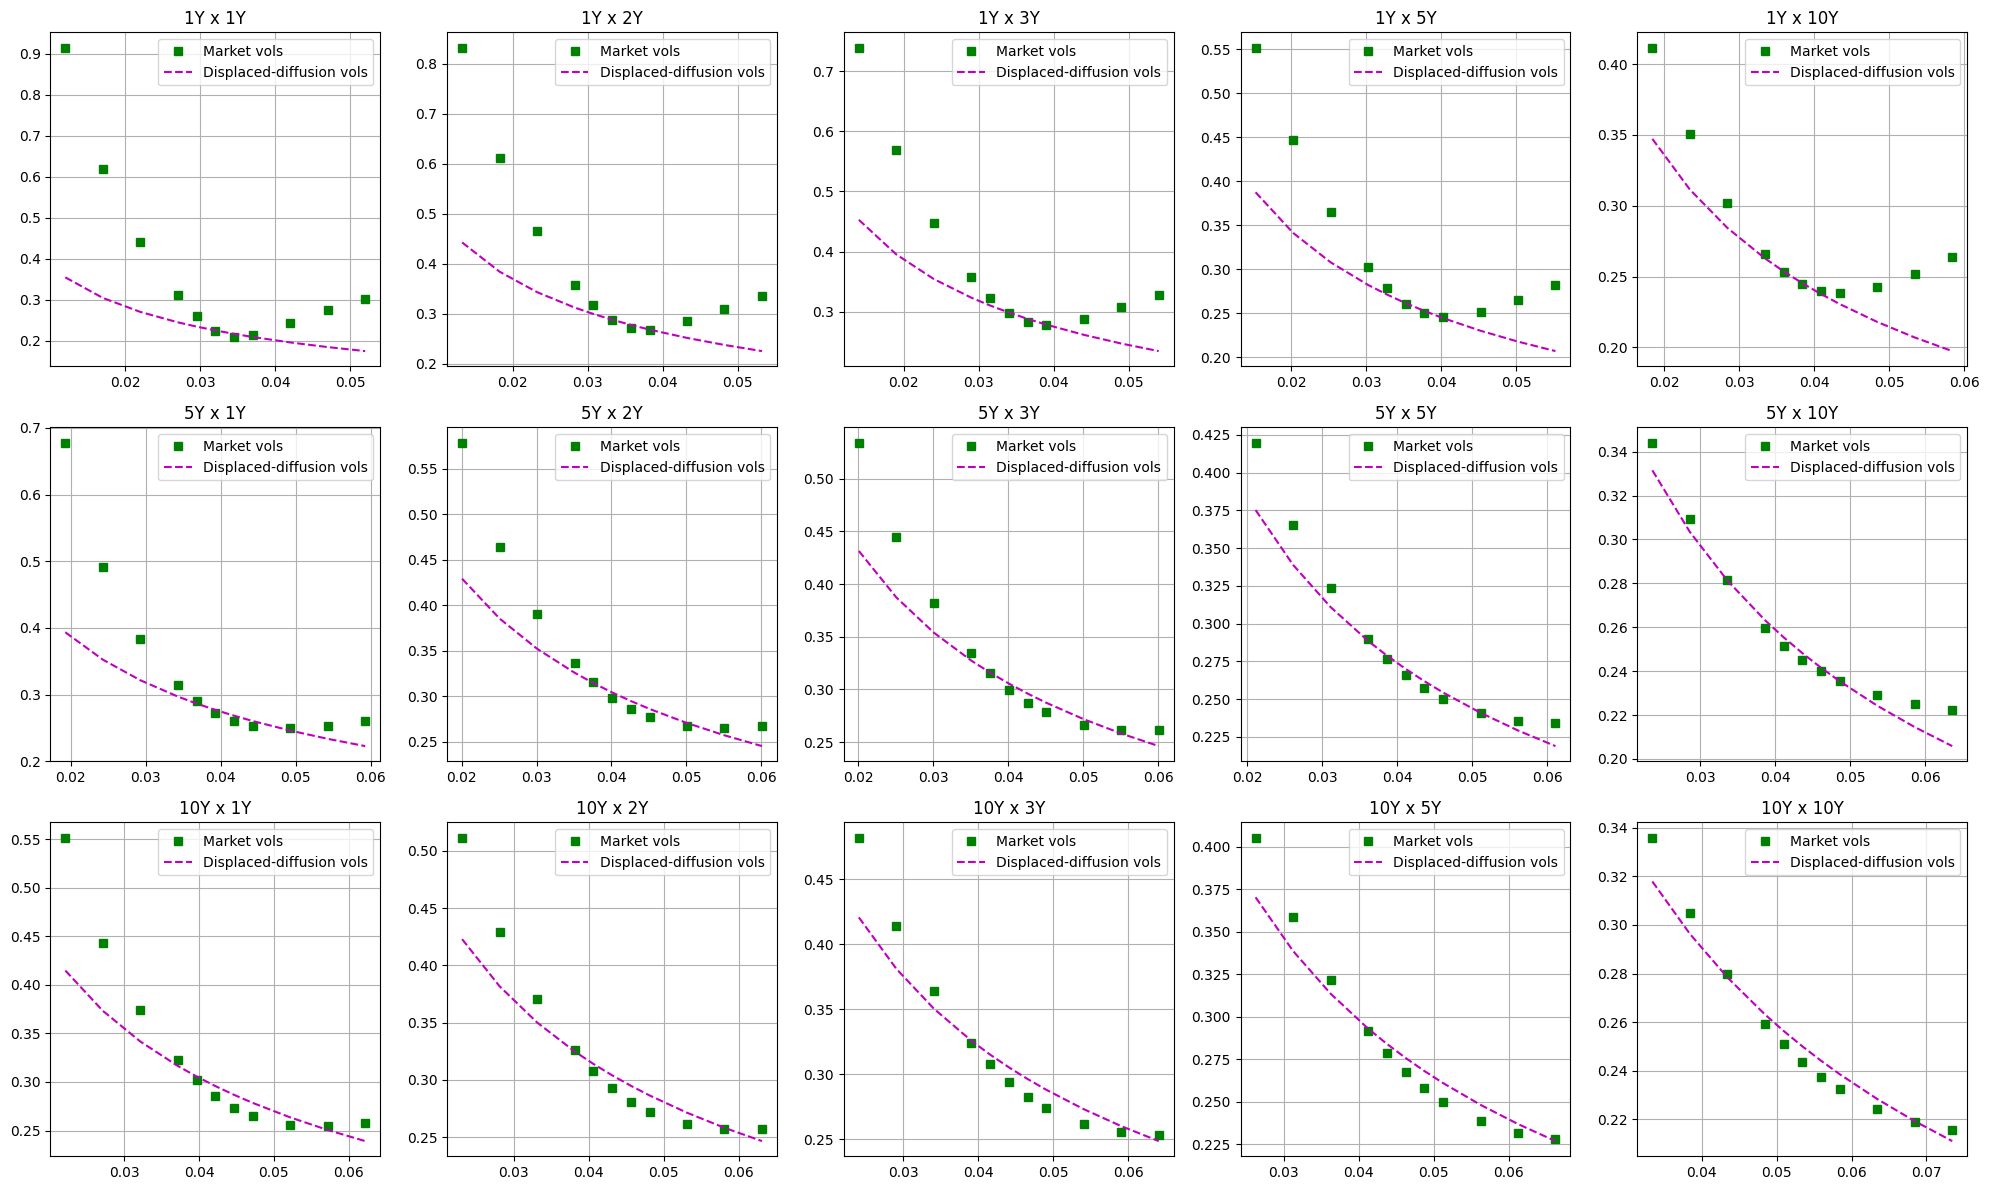

In [6]:
# Set up the 3 x 5 grid of subplots
fig, axes = plt.subplots(3, 5, figsize=(20, 12), tight_layout=True)
axes = axes.flatten()  # Flatten to easily iterate through the subplot axes

# Loop through the data and plot on each subplot
for idx, (ax, (_, row)) in enumerate(zip(axes, displaced_diffusion_results_df.iterrows())):
    ddvols = []
    temp_expiry = row["Expiry"]
    temp_tenor = row["Tenor"]
    temp_df = data_df[(data_df["Expiry"] == temp_expiry) & (data_df["Tenor"] == temp_tenor)].copy()
    temp_F = temp_df["parSwap"].iloc[0]
    temp_expiry_T = temp_df["Expiry_no"].iloc[0]
    temp_tenor_T = temp_df["Tenor_no"].iloc[0]
    temp_PVBP = PVBP_calculation(temp_expiry_T, temp_tenor_T)

    for K in temp_df['strike']:
        ddvols.append(ImpVol(temp_F, K, temp_PVBP, temp_expiry_T, row["Sigma"], row["Beta"]))

    # Plot on the corresponding subplot
    ax.plot(temp_df['strike'], temp_df['impliedVol'], 'gs', label='Market vols')
    ax.plot(temp_df['strike'], ddvols, 'm--', label='Displaced-diffusion vols')
    ax.set_title(f"{temp_expiry} x {temp_tenor}")
    ax.legend()
    ax.grid(True)

# Hide any unused subplots
for i in range(len(displaced_diffusion_results_df), len(axes)):
    fig.delaxes(axes[i])

# Display the full figure with subplots
plt.show()

2. Calibrate the SABR model to the swaption market data using $\beta = 0.9$, and document
    - a table of $\alpha$ parameters
    - a table of $\rho$ parameters
    - a table of $\nu$ parameters

<u>Background</u><br>
The implied Black volatility of the SABR model is given by
  \begin{equation*}
    \begin{split}
      &\sigma_{\mbox{SABR}}(F_0, K, \alpha, \beta, \rho, \nu) \\
      &= \frac{\alpha}{(F_0K)^{(1-\beta)/2}\left\{ 1 + \frac{(1-\beta)^2}{24}\log^2\left(\frac{F_0}{K}\right) + \frac{(1-\beta)^4}{1920}\log^4\left(\frac{F_0}{K}\right) + \cdots\right\} } \\
      &\;\;\;\times \frac{z}{x(z)} \times \left\{ 1 + \left[
          \frac{(1-\beta)^2}{24}
          \frac{\alpha^2}{(F_0K)^{1-\beta}}+\frac{1}{4}\frac{\rho\beta\nu\alpha}{(F_0K)^{(1-\beta)/2}}+\frac{2-3\rho^2}{24}\nu^2\right]
        T + \cdots \right.
    \end{split}
  \end{equation*}
  where
  \begin{equation*}
    \begin{split}
      z = \frac{\nu}{\alpha} (F_0K)^{(1-\beta)/2}
      \log\left(\frac{F_0}{K}\right),\,\,x(z) = \log \left[ \frac{\sqrt{1-2\rho z+z^2}+z -\rho}{1-\rho}\right].
    \end{split}
  \end{equation*}
In this context, we consider the case where $\beta=0.9$ with zero risk-free rate, i.e., $r=0$. The swaption price under the SABR model is:
$$
V_{n,N}(0)=P_{n+1,N}(0)\,\,\mbox{BlackScholes}(S_{n,N}(0), K, 0, \sigma_{\mbox{SABR}}, T),
$$
where
$$
\mbox{BlackScholes}(S_{n,N}(0), K, 0, \sigma_{\mbox{SABR}}, T)=\begin{cases}S_{n,N}(0)\Phi(d_1)-K\Phi(d_2)&(\text{payer})\\K\Phi(-d_2)-S_{n,N}(0)\Phi(-d_1)&(\text{receiver}),\end{cases}\,\,d_1=\frac{\log\frac{S_{n,N}(0)}{K}+\frac{1}{2}\sigma_{\mbox{SABR}}^2T}{\sigma_{\mbox{SABR}}\sqrt{T}},\,\,d_2=d_1-\sigma_{\mbox{SABR}}\sqrt{T}.
$$

In [7]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

The definition above contains the function

\begin{equation*}
\begin{split}
\mbox{SABR}(F, K, T, \alpha, \beta, \rho, \nu)
\end{split}
\end{equation*}

The function returns a volatility $\sigma_{\mbox{SABR}}$ for the Black76Lognormal call or put option formula, so that

\begin{equation*}
\begin{split}
\mbox{Call price} &= \mbox{BlackScholesCall}(S, K, 0, \sigma_{\mbox{SABR}}, T) \\
\mbox{Put price} &= \mbox{BlackScholesPut}(S, K, 0, \sigma_{\mbox{SABR}}, T) \\
\end{split}
\end{equation*}

How do we determine the parameters $\alpha$, $\rho$ and $\nu$?
- We choose them so that the output of the SABR model matches the implied volatilities observed in the market.
- We refer to this process as "model calibration".

In other words, defining

  \begin{equation*}
    \begin{split}
      \sigma_{\mbox{Mkt}}(K_1) - \mbox{SABR}(F, K_1, T, \alpha, 0.9, \rho, \nu) &= \epsilon_1 \\
      \sigma_{\mbox{Mkt}}(K_2) - \mbox{SABR}(F, K_2, T, \alpha, 0.9, \rho, \nu) &= \epsilon_2 \\
      \vdots&\\
      \sigma_{\mbox{Mkt}}(K_n) - \mbox{SABR}(F, K_n, T, \alpha, 0.9, \rho, \nu) &= \epsilon_n \\
    \end{split}
  \end{equation*}

We want to minimize the sum of squared error terms as follows:
  
  \begin{equation*}
    \begin{split}
      \min_{\substack{\alpha,\; \rho,\; \nu}} \;\sum_{i=1}^n \epsilon_i^2
    \end{split}
  \end{equation*}

We use the "least_squares" algorithm in "scipy" package to calibrate the SABR model parameters:

In [8]:
beta = 0.9

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err

# SABR calibration
sabr_results = []

for expiry in expiry_list:
    for tenor in tenor_list:
        calibrate_df = data_df[(data_df['Expiry'] == expiry) & (data_df['Tenor'] == tenor)].copy()
        T = calibrate_df['Expiry_no'].iloc[0]
        r = 0
        F = calibrate_df['parSwap'].iloc[0]

        initialGuess = [0.02, 0.2, 0.1]
        res = least_squares(lambda x: sabrcalibration(x,
                                                      calibrate_df['strike'].values,
                                                      calibrate_df['impliedVol'].values,
                                                      F,
                                                      T),
                            initialGuess,
                            bounds=([0, -1, 0], [np.inf, 1, np.inf]),
        )
        alpha = res.x[0]
        rho = res.x[1]
        nu = res.x[2]

        temp = [expiry, tenor, alpha, nu, rho]
        sabr_results.append(temp)

# Generate a dataframe containing the SABR model calibration results
sabr_results_df = pd.DataFrame(sabr_results)
sabr_results_df.columns = ["Expiry", "Tenor", "Alpha", "Nu", "Rho"]
sabr_results_df

,Expiry,Tenor,Alpha,Nu,Rho
0,1Y,1Y,0.139067,2.049536,-0.633241
1,1Y,2Y,0.184652,1.677369,-0.525115
2,1Y,3Y,0.196852,1.438123,-0.482846
3,1Y,5Y,0.178052,1.064876,-0.414420
4,1Y,10Y,0.171083,0.777804,-0.264656
5,5Y,1Y,0.166263,1.337576,-0.583927
6,5Y,2Y,0.198497,1.058899,-0.542490
7,5Y,3Y,0.207231,0.933328,-0.536731
8,5Y,5Y,0.188238,0.680006,-0.493564
9,5Y,10Y,0.171191,0.530820,-0.375759


In [9]:
# Generate the table
alpha_df = sabr_results_df[["Expiry", "Tenor", "Alpha"]].copy()

# Define the desired order for rows (expiry) and columns (tenor)
original_expiry_order = ["1Y", "5Y", "10Y"]
original_tenor_order = ["1Y", "2Y", "3Y", "5Y", "10Y"]

# Pivot the DataFrame
alpha_pivot = alpha_df.pivot(index="Expiry", columns="Tenor", values="Alpha")

# Reindex to ensure the correct order
alpha_pivot = alpha_pivot.reindex(index=original_expiry_order, columns=original_tenor_order)

# Add a name for the columns to reflect "Alpha (Expiry\Tenor)"
alpha_pivot.columns.name = "Alpha (Expiry\\Tenor)"
alpha_pivot.index.name = None  # Remove index name if not desired
alpha_pivot

Alpha (Expiry\Tenor),1Y,2Y,3Y,5Y,10Y
1Y,0.139067,0.184652,0.196852,0.178052,0.171083
5Y,0.166263,0.198497,0.207231,0.188238,0.171191
10Y,0.176061,0.191402,0.200019,0.181849,0.164772


In [10]:
# Generate the table
nu_df = sabr_results_df[["Expiry", "Tenor", "Nu"]].copy()

# Define the desired order for rows (expiry) and columns (tenor)
original_expiry_order = ["1Y", "5Y", "10Y"]
original_tenor_order = ["1Y", "2Y", "3Y", "5Y", "10Y"]

# Pivot the DataFrame
nu_pivot = nu_df.pivot(index="Expiry", columns="Tenor", values="Nu")

# Reindex to ensure the correct order
nu_pivot = nu_pivot.reindex(index=original_expiry_order, columns=original_tenor_order)

# Add a name for the columns to reflect "Rho (Expiry\Tenor)"
nu_pivot.columns.name = "Nu (Expiry\\Tenor)"
nu_pivot.index.name = None  # Remove index name if not desired
nu_pivot

Nu (Expiry\Tenor),1Y,2Y,3Y,5Y,10Y
1Y,2.049536,1.677369,1.438123,1.064876,0.777804
5Y,1.337576,1.058899,0.933328,0.680006,0.530820
10Y,1.000675,0.914422,0.853172,0.704893,0.600363


In [11]:
# Generate the table
rho_df = sabr_results_df[["Expiry", "Tenor", "Rho"]].copy()

# Define the desired order for rows (expiry) and columns (tenor)
original_expiry_order = ["1Y", "5Y", "10Y"]
original_tenor_order = ["1Y", "2Y", "3Y", "5Y", "10Y"]

# Pivot the DataFrame
rho_pivot = rho_df.pivot(index="Expiry", columns="Tenor", values="Rho")

# Reindex to ensure the correct order
rho_pivot = rho_pivot.reindex(index=original_expiry_order, columns=original_tenor_order)

# Add a name for the columns to reflect "Rho (Expiry\Tenor)"
rho_pivot.columns.name = "Rho (Expiry\\Tenor)"
rho_pivot.index.name = None  # Remove index name if not desired
rho_pivot

Rho (Expiry\Tenor),1Y,2Y,3Y,5Y,10Y
1Y,-0.633241,-0.525115,-0.482846,-0.414420,-0.264656
5Y,-0.583927,-0.542490,-0.536731,-0.493564,-0.375759
10Y,-0.540240,-0.532954,-0.531122,-0.490882,-0.420789


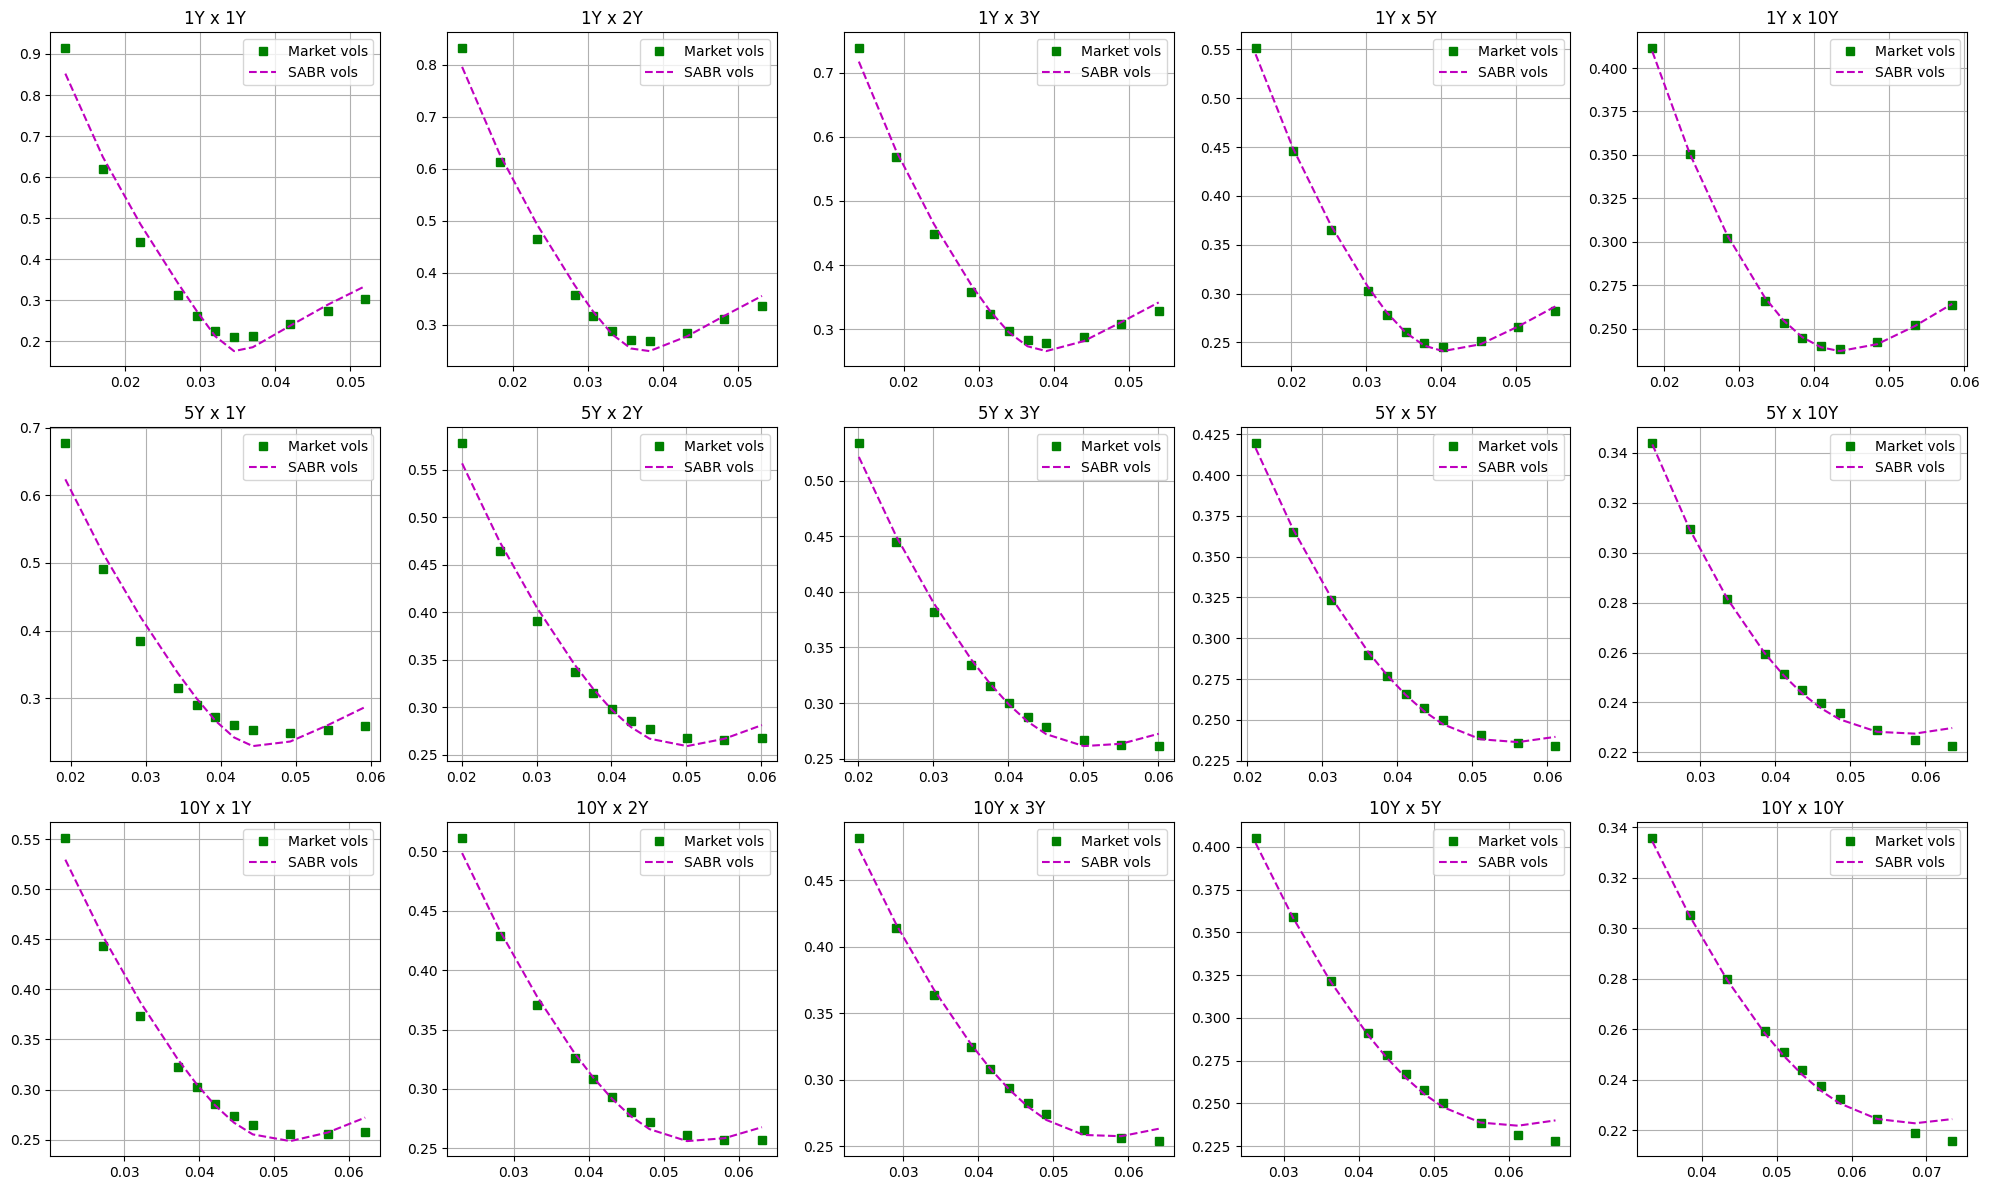

In [12]:
# Set up the 3 x 5 grid of subplots
fig, axes = plt.subplots(3, 5, figsize=(20, 12), tight_layout=True)
axes = axes.flatten()  # Flatten to easily iterate through the subplot axes

# Loop through the data and plot on each subplot
for idx, (ax, (_, row)) in enumerate(zip(axes, sabr_results_df.iterrows())):
    sabrvols = []
    temp_expiry = row["Expiry"]
    temp_tenor = row["Tenor"]
    temp_df = data_df[(data_df["Expiry"] == temp_expiry) & (data_df["Tenor"] == temp_tenor)].copy()
    temp_F = temp_df["parSwap"].iloc[0]
    temp_T = temp_df["Expiry_no"].iloc[0]

    for K in temp_df['strike']:
        sabrvols.append(SABR(temp_F, K, temp_T, row["Alpha"], 0.9, row["Rho"], row["Nu"]))

    # Plot on the corresponding subplot
    ax.plot(temp_df['strike'], temp_df['impliedVol'], 'gs', label='Market vols')
    ax.plot(temp_df['strike'], sabrvols, 'm--', label='SABR vols')
    ax.set_title(f"{temp_expiry} x {temp_tenor}")
    ax.legend()
    ax.grid(True)

# Hide any unused subplots
for i in range(len(sabr_results_df), len(axes)):
    fig.delaxes(axes[i])

# Display the full figure with subplots
plt.show()

In [13]:
# Collated parameters
params_df = sabr_results_df.merge(displaced_diffusion_results_df, on =["Expiry", "Tenor"], how = "outer")
params_df.to_csv("calibrated_params.csv")
params_df

,Expiry,Tenor,Alpha,Nu,Rho,Sigma,Beta
0,10Y,10Y,0.164772,0.600363,-0.420789,0.2437,4.459102e-03
1,10Y,1Y,0.176061,1.000675,-0.540240,0.2854,3.216240e-07
2,10Y,2Y,0.191402,0.914422,-0.532954,0.2928,1.000058e-07
3,10Y,3Y,0.200019,0.853172,-0.531122,0.2940,1.992773e-06
4,10Y,5Y,0.181849,0.704893,-0.490882,0.2674,2.447620e-05
5,1Y,10Y,0.171083,0.777804,-0.264656,0.2447,2.586166e-07
6,1Y,1Y,0.139067,2.049536,-0.633241,0.2250,4.831147e-07
7,1Y,2Y,0.184652,1.677369,-0.525115,0.2872,3.578737e-08
8,1Y,3Y,0.196852,1.438123,-0.482846,0.2978,1.910510e-07
9,1Y,5Y,0.178052,1.064876,-0.414420,0.2607,6.681484e-07


3. Price the following swaptions using the calibrated displaced-diffusion and SABR model:
    - payer $2y\times10y$; $K = 1\%,2\%,3\%,4\%,5\%,6\%,7\%,8\%$
    - receiver $8y\times10y$; $K = 1\%,2\%,3\%,4\%,5\%,6\%,7\%,8\%$
  
We can do this using the following formulae, with step size 0.5:
$$
\text{Payer 2$y$ $\times$ 10$y$ par swap rate} = \frac{\sum\limits_{i=2.5}^{12} D_o(0,t_i)\times L(t_{i-0.5}, t_i)}{0.5\sum\limits_{i=2.5}^{12} D_o(0,t_i)}\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\text{Payer 8$y$ $\times$ 10$y$ par swap rate} = \frac{\sum\limits_{i=8.5}^{18} D_o(0,t_i)\times L(t_{i-0.5}, t_i)}{0.5\sum\limits_{i=8.5}^{18} D_o(0,t_i)}
$$

In [14]:
# Calculate the LIBOR forward rate
def LIBOR_forward(D1,D2,delta = 0.5):
    L1 = (D1/D2-1)/delta
    return L1

# Interpolate the LIBOR discount factor
def LIBORDifInterp(tenor):
    xp = list(discount_factors_df['Tenor'])
    yp = list(discount_factors_df['LIBOR discount factor'])
    return np.interp(tenor, xp, yp)

# Calculate the float leg of a swap
def floatLeg(expiry, tenor, delta=0.5):
    m = int(tenor/delta)
    summa = 0
    for i in range(1, m + 1):
        loc = expiry + i * delta
        summa += OISDifInterp(loc)*LIBOR_forward(LIBORDifInterp(loc - delta), LIBORDifInterp(loc), delta)
    return summa * delta

# Par swap rate based on tenor and expiry
def Swaption(expiry, tenor):
    return floatLeg(expiry, tenor) / PVBP_calculation(expiry, tenor)

# Interpolate the calibrated parameters using a cubic spline
from scipy.interpolate import CubicSpline

def ParameterInterp(T, N, data):
    splied_from_expiry = []
    exp = [int(i) for i in data.index.tolist()]
    for i in data.columns:
        result = CubicSpline(exp, data[i], bc_type=((2, 0.0), (2, 0.0)), extrapolate=True)
        splied_from_expiry.append(result)

    extract = []
    for i in range(len(splied_from_expiry)):
        extract.append(splied_from_expiry[i](T))

    result = CubicSpline([1,2,3,5,10], extract, bc_type=((2, 0.0), (2, 0.0)), extrapolate=True)
    return float(result(N))

K_list = [i/100 for i in range(1,9)]
swaptions_pricing =\
(
    pd
    .DataFrame(index = ['Pay 2y x 10y under displaced-diffusion', 'Pay 2y x 10y under SABR',
                        'Rec 8y x 10y under displaced-diffusion', 'Rec 8y x 10y under SABR'],
               columns = K_list)
)

alpha_pivoted = pd.DataFrame(data = params_df['Alpha'].values.reshape(3,5), index = [1,5,10], columns = [1,2,3,5,10])
rho_pivoted = pd.DataFrame(data = params_df['Rho'].values.reshape(3,5), index = [1,5,10], columns = [1,2,3,5,10])
nu_pivoted = pd.DataFrame(data = params_df['Nu'].values.reshape(3,5), index = [1,5,10], columns = [1,2,3,5,10])
beta_pivoted = pd.DataFrame(data = params_df['Beta'].values.reshape(3,5), index = [1,5,10], columns = [1,2,3,5,10])
sigma_pivoted = pd.DataFrame(data = params_df['Sigma'].values.reshape(3,5), index = [1,5,10], columns = [1,2,3,5,10])

# Payer 2y x 10y
alpha_Pay = ParameterInterp(2, 10, alpha_pivoted)
rho_Pay = ParameterInterp(2, 10, rho_pivoted)
nu_Pay = ParameterInterp(2, 10, nu_pivoted)
beta_Pay = ParameterInterp(2, 10, beta_pivoted)
sigma_Pay = ParameterInterp(2, 10, sigma_pivoted)
F_Pay = Swaption(2,10)

for k in K_list:
    PVBP_2_10 = PVBP_calculation(2, 10)
    PricePayDD = DisplacedDiffusionCall(F_Pay,k, PVBP_2_10, sigma_Pay, 2, beta_Pay) 
    PricePaySABR = Black76Call(F_Pay,k, PVBP_2_10, SABR(F_Pay, k, 2, alpha_Pay, 0.9, rho_Pay, nu_Pay), 2)
    swaptions_pricing.loc['Pay 2y x 10y under displaced-diffusion', k] = PricePayDD
    swaptions_pricing.loc['Pay 2y x 10y under SABR', k] = PricePaySABR

# Receiver 8y x 10y
alpha_Rec = ParameterInterp(8, 10, alpha_pivoted)
rho_Rec = ParameterInterp(8, 10, rho_pivoted)
nu_Rec = ParameterInterp(8, 10, nu_pivoted)
beta_Rec = ParameterInterp(8, 10, beta_pivoted)
sigma_Rec = ParameterInterp(8, 10, sigma_pivoted)
F_Rec = Swaption(8,10)

for k in K_list:
    PVBP_8_10 = PVBP_calculation(8, 10)
    PriceRecDD = DisplacedDiffusionPut(F_Rec, k, PVBP_8_10, sigma_Rec, 8, beta_Rec) 
    PriceRecSABR = Black76Put(F_Rec, k, PVBP_8_10, SABR(F_Rec, k, 8, alpha_Rec, 0.9, rho_Rec, nu_Rec), 8)
    swaptions_pricing.loc['Rec 8y x 10y under displaced-diffusion', k] = PriceRecDD
    swaptions_pricing.loc['Rec 8y x 10y under SABR', k] = PriceRecSABR

swaptions_pricing.columns.name = "Calibrated swaption\\Strike price"
swaptions_pricing

Calibrated swaption\Strike price,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08
Pay 2y x 10y under displaced-diffusion,0.288851,0.196827,0.115971,0.055779,0.020693,0.005643,0.00109,0.000145
Pay 2y x 10y under SABR,0.291743,0.202217,0.119619,0.053665,0.020036,0.009649,0.006029,0.004354
Rec 8y x 10y under displaced-diffusion,0.02475,0.041342,0.065483,0.098652,0.141833,0.195308,0.258599,0.33057
Rec 8y x 10y under SABR,0.049404,0.079499,0.102818,0.12464,0.154958,0.212199,0.294126,0.385348
